# CIFAR-10 Using Transfer Learning with Generator

## Importing necessary libraries

In [1]:
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Creating a function to preprocess X for xception and converting Y into one-hot encoding 

In [2]:
def preprocess_data(X, Y):
    """
    function that pre-processes the CIFAR10 dataset as per
    densenet model requirements for input images
    labels are one-hot encoded
    """
    X = K.applications.xception.preprocess_input(X)
    Y = K.utils.to_categorical(Y)
    return X, Y

## Loading and preprocessing the CIFAR-10 dataset

In [3]:
# 50,000 training images and 10,000 test images used as validation data
(x_train, y_train), (x_test, y_test) = K.datasets.cifar10.load_data()

# for calculating various metrics
test_target = y_test

x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

## Building a model based on Xception using Transfer Learning and adding our own classifier on top of it

In [4]:
# weights are initialized as per the he et al. method
initializer = K.initializers.he_normal()
input_tensor = K.Input(shape=(32, 32, 3))

# resize images to the image size on which the network was pre-trained (i.e 72 X 72)
resized_images = K.layers.Lambda(lambda image: tf.image.resize(image, (72, 72)))(input_tensor)
model = K.applications.xception.Xception(include_top=False,
                                   weights='imagenet',
                                   input_tensor=resized_images,
                                   input_shape=(72, 72, 3),
                                   pooling='max')

# make the weights and biases of the base model non-trainable
# by "freezing" each layer of the DenseNet201 network
for layer in model.layers:
    layer.trainable = False
output = model.layers[-1].output

# reshape the output feature map of the base model before passing the data on to the Dense layers of the classifier head
flatten = K.layers.Flatten()
output = flatten(output)
layer_256 = K.layers.Dense(units=256,
                           activation='relu',
                           kernel_initializer=initializer,
                           kernel_regularizer=K.regularizers.l2())

output = layer_256(output)

dropout = K.layers.Dropout(0.3)
output = dropout(output)

softmax = K.layers.Dense(units=10,
                         activation='softmax',
                         kernel_initializer=initializer,
                         kernel_regularizer=K.regularizers.l2())
output = softmax(output)

model = K.models.Model(inputs=input_tensor, outputs=output)


## Compiling the model

In [5]:
model.compile(
         optimizer=K.optimizers.Adam(learning_rate=1e-4),
         loss='categorical_crossentropy',
         metrics=['accuracy'])

## Creating training and validation generator and fitting the model

In [6]:
train_datagen = K.preprocessing.image.ImageDataGenerator(horizontal_flip=True)
train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size=32)

val_datagen = K.preprocessing.image.ImageDataGenerator(
                                        horizontal_flip=True)
val_generator = val_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32)

train_steps_per_epoch = x_train.shape[0] // 32
val_steps_per_epoch = x_test.shape[0] // 32

history = model.fit(train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=val_generator,
                    validation_steps=val_steps_per_epoch,
                    epochs=5,
                    shuffle=True,
                    verbose=1)

Epoch 1/5
1562/1562 [==============================] - 38s 22ms/step - loss: 5.7513 - accuracy: 0.5671 - val_loss: 3.1275 - val_accuracy: 0.7192
Epoch 2/5
1562/1562 [==============================] - 32s 20ms/step - loss: 2.7035 - accuracy: 0.7305 - val_loss: 1.8239 - val_accuracy: 0.7363
Epoch 3/5
1562/1562 [==============================] - 32s 20ms/step - loss: 1.6437 - accuracy: 0.7458 - val_loss: 1.3140 - val_accuracy: 0.7416
Epoch 4/5
1562/1562 [==============================] - 32s 21ms/step - loss: 1.2319 - accuracy: 0.7508 - val_loss: 1.1259 - val_accuracy: 0.7380
Epoch 5/5
1562/1562 [==============================] - 32s 20ms/step - loss: 1.0683 - accuracy: 0.7530 - val_loss: 1.0230 - val_accuracy: 0.7456


## Accuracy

In [7]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

313/313 [==============================] - 6s 17ms/step - loss: 1.0253 - accuracy: 0.7414
Test Accuracy: 74.14%


In [8]:
prediction = model.predict(x_test)
prediction = np.argmax(prediction, axis=1)
print(prediction)
print(prediction.shape)

[3 8 8 ... 5 0 7]
(10000,)


## Classification Report

In [9]:
from sklearn import metrics
#calculating various metrics
print("\n-------------------------Accuracy Score----------------------------\n\t\t\t     ",metrics.accuracy_score(test_target, prediction, normalize= True))
print("\n---------------------Classification Report-------------------------\n",metrics.classification_report(test_target, prediction))
print("\n--------------------------Confusion Matrix-------------------------\n",metrics.confusion_matrix(test_target,prediction))


-------------------------Accuracy Score----------------------------
			      0.7414

---------------------Classification Report-------------------------
               precision    recall  f1-score   support

           0       0.71      0.78      0.74      1000
           1       0.82      0.85      0.83      1000
           2       0.74      0.66      0.70      1000
           3       0.64      0.59      0.61      1000
           4       0.71      0.62      0.66      1000
           5       0.67      0.75      0.71      1000
           6       0.67      0.82      0.74      1000
           7       0.84      0.72      0.77      1000
           8       0.81      0.85      0.83      1000
           9       0.84      0.77      0.81      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000


--------------------------Confusion Matrix-------------------------
 [[776  24  32  2

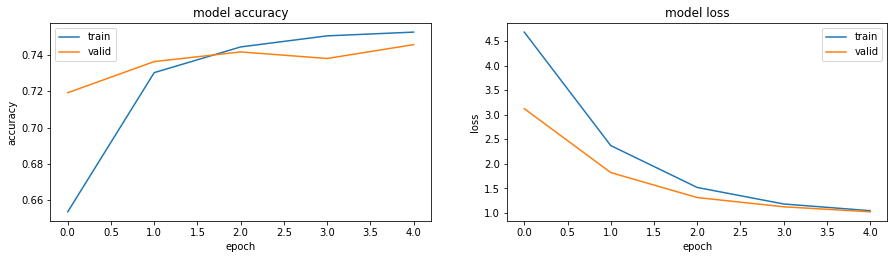

In [10]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()
